In [7]:
# libraries
import os
from dotenv import load_dotenv
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# custom functions
from utils import connect_to_db

# scikit-learn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
# connect to database and get data

conn = connect_to_db(env="dev")
cursor = conn.cursor()

ticker = 'GOOGL'
googl_data = pd.read_sql_query('''
                               SELECT * FROM public.stocks WHERE ticker = 'GOOGL' ORDER BY date ASC;
                               ''', conn)
googl_data = googl_data.drop(columns=['ticker'])
# price_data = price_data.set_index('date')
googl_data = pd.DataFrame(googl_data)
googl_data


/var/folders/6v/kx15yglj19173xqgq1g6f46r0000gn/T/ipykernel_51259/1908929643.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  googl_data = pd.read_sql_query('''


,id,date,open_price,close_price,high_price,low_price,volume
0,39733,2004-08-19 00:00:00-07:00,2.50,2.50,2.60,2.40,893181924
1,39734,2004-08-20 00:00:00-07:00,2.52,2.70,2.72,2.51,456686856
2,39735,2004-08-23 00:00:00-07:00,2.76,2.73,2.83,2.72,365122512
3,39736,2004-08-24 00:00:00-07:00,2.78,2.62,2.79,2.59,304946748
4,39737,2004-08-25 00:00:00-07:00,2.62,2.65,2.70,2.59,183772044
...,...,...,...,...,...,...,...
5063,830989,2024-10-01 00:00:00-07:00,167.69,166.99,169.16,164.58,28338100
5064,978442,2024-10-02 00:00:00-07:00,166.42,165.86,167.52,164.73,17760200
5065,1027605,2024-10-03 00:00:00-07:00,164.41,165.86,166.64,163.92,15073100
5066,1224271,2024-10-04 00:00:00-07:00,168.06,167.06,168.23,165.48,19047400


In [13]:
# convert date to 
googl_data['date'] = pd.to_datetime(googl_data['date'], utc=True)

In [14]:
# use sci-kit learn to create a random forest classifier
# split data into training and testing data
X = googl_data.drop(columns=['close_price'])
y = googl_data['close_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# create the random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

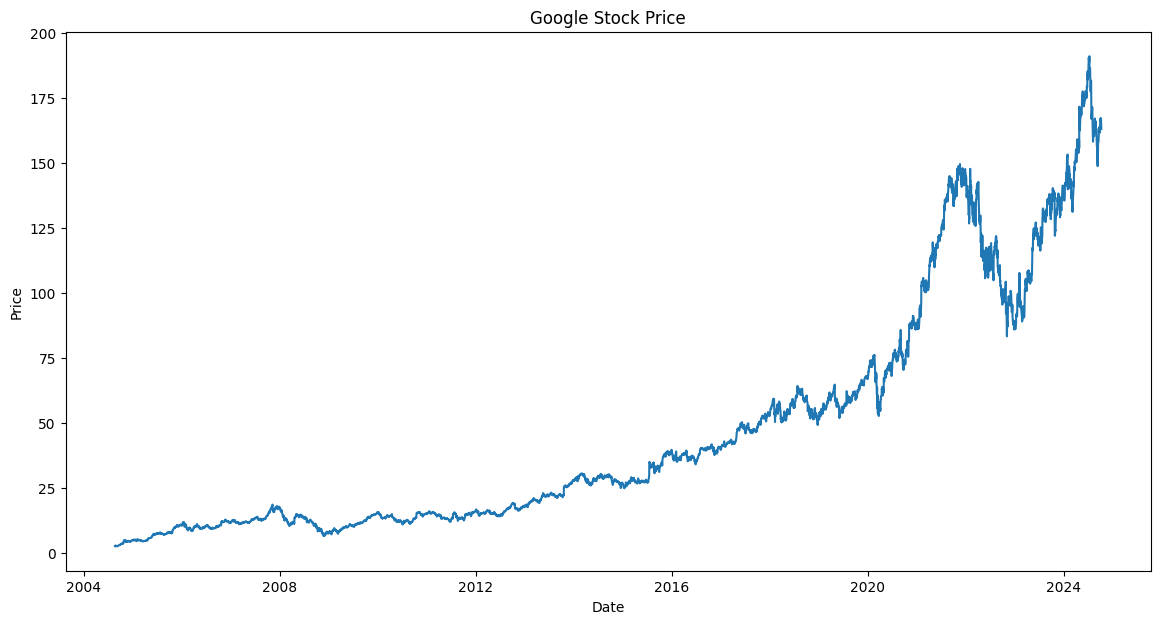

In [4]:
# plot the data
plt.figure(figsize=(14, 7))
plt.plot(googl_data['date'], googl_data['close_price'])
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# load the stock data from the database

selected_stock = 'XEQT.TO'
stock_data = pd.read_sql(
    f"SELECT * FROM public.stocks WHERE ticker = '{selected_stock}'",
    conn)

stock_data['date'] = pd.to_datetime(stock_data['date'])

stock_data

# plot scatter plot of close price vs date
plt.scatter(stock_data['date'], stock_data['close_price'])

cursor.close()